In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import itertools
assetsDir = "../assets/"

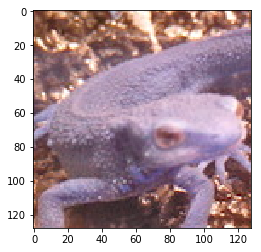

In [2]:
img = cv2.imread(assetsDir+"imori.jpg")
plt.imshow(img)

### Q.1. チャネル入れ替え

## 注意点
`img = cv2.imread(assetsDir+"imori.jpg")`
`print(type(img))` 
> #class 'numpy.ndarray'
`img[:,:,0], img[:,:,2] = img[:,:,2], img[:,:,0]`

ではだめ<br>
なぜなら、img\[:,:,\]はビューであり、実態ではない → ポインタは入れ替わらない<br>
参考 https://qiita.com/koshian2/items/c5f2fb548b9bffe80fdf#numpy配列のスライス同士のスワップがng

In [3]:
test = np.array([[1,2],[3,4]])
test[:,0], test[:,1] = test[:,1], test[:,0]
print(test)
print("↑OMG...",end="\n\n")

test = np.array([[1,2],[3,4]])
test[0], test[1] = test[1], test[0]
print(test)
print("↑OMG...",end="\n\n")

test  = np.array([[1,2],[3,4]])
test2 = np.array([[5,6],[7,8]])
test, test2 = test2, test
print(test)
print(test2)

[[2 2]
 [4 4]]
↑OMG...

[[3 4]
 [3 4]]
↑OMG...

[[5 6]
 [7 8]]
[[1 2]
 [3 4]]


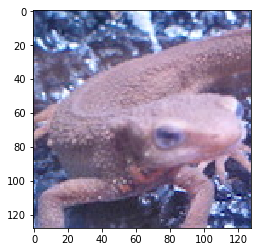

In [4]:
# BGR to RGB
img = cv2.imread(assetsDir+"imori.jpg")
img[:,:,0], img[:,:,2] = img[:,:,2], img[:,:,0].copy()
# 2つめをコピーしておけばよい
plt.imshow(img)

In [5]:
def readImg(imgName):
    img = cv2.imread(assetsDir+imgName)
    img[:,:,0], img[:,:,2] = img[:,:,2], img[:,:,0].copy()
    return img
def img2RGB(img):
    R,G,B = *[img[:,:,i] for i in range(3)], 
    return R,G,B
def RGB2img(R,G,B):
    img = np.empty((128, 128, 3),dtype=np.uint8)
    img[:,:,0],img[:,:,1],img[:,:,2] = R,G,B
    return img

## Q.2. グレースケール化

In [6]:
def img2Grey(img):
    return img[:,:,0]*0.2126 + img[:,:,1]*0.7152 + img[:,:,2]*0.0722

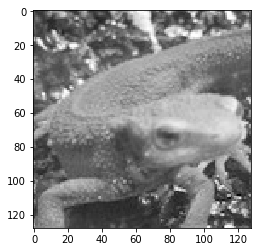

In [7]:
img = readImg("imori.jpg")
s = img2Grey(img)
img = RGB2img(s,s,s)
plt.imshow(img)

## Q.3. 二値化

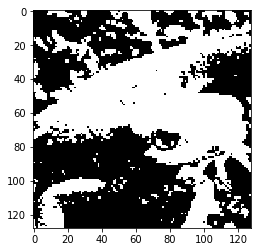

In [8]:
img = readImg("imori.jpg")
s = img2Grey(img)
p = np.where(s<128,0,255)
img = RGB2img(p,p,p)
plt.imshow(img)

## Q.4. 大津の二値化

参考 https://ch.nicovideo.jp/zigzagzackey/blomaga/ar1388260 <br>
+ データ数:$C_t=count(D), C_0=count(D_0), C_1=count(D_1)$<br>
+ 平均:$m_t, m_0, m_1$<br>
+ 分散$S_t=\sum_i{(x_i-m_t)^2/C}, \forall{x_i}\in{D}$, $S_0,S_1$(それぞれのクラスでの分散)<br>
クラス内分散$S_w≡(C_0/C_t)(\sum_{x_i\in{D_0}}(x_i-m_0)^2/C_0)+(C_1/C_t)(\sum_{x_i\in{D_1}}(x_i-m_1)^2/C_1)=(C_0/C_t)S_0+(C_1/C_t)S_1$<br>
クラス間分散$S_b≡(C_0/C_t)(m_0-m_t)^2+(C_1/C_t)(m_1-m_t)^2$<br> 
$= (C_0/C_t)(m_0-(m_0C_0+m_1C_1)/C_t)^2+(C_1/C_t)(m_1-(m_0C_0+m_1C_1)/C_t)^2$<br>
$= (C_0/C_t)((m_0-m_1)C_1/C_t)^2+(C_1/C_t)((m_0-m_1)C_0/C_t)^2 $<br>
$= (m_0-m_1)^2(C_0/C_t)(C_1/C_t)((C_1/C_t)+(C_0/C_t))$<br>
$= (m_0-m_1)^2(C_0/C_t)(C_1/C_t)$<br>
<br>
$S_b+S_w=(C_0/C_t)(m_0-m_t)^2+(C_1/C_t)(m_1-m_t)^2+(C_0/C_t)(\sum_{x_i\in{D_0}}(x_i-m_0)^2/C_0)+(C_1/C_t)(\sum_{x_i\in{D_1}}(x_i-m_1)^2/C_1)$<br>
$=(C_0/C_t)(m_0-m_t)^2 + (C_1/C_t)(m_1-m_t)^2 + (C_0/C_t)((\sum_{x_i\in{D_0}}x_i^2/C_0)-m_0^2)+(C_1/C_t)((\sum_{x_i\in{D_1}}x_i^2/C_1)-m_1^2)$<br>
$=(C_0/C_t)((\sum_{x_i\in{D_0}}x_i^2/C_0)-m_0^2+(m_0-m_t)^2)+(C_1/C_t)((\sum_{x_i\in{D_1}}x_i^2/C_1)-m_1^2+(m_1-m_t)^2)$<br>
$=(C_0/C_t)((\sum_{x_i\in{D_0}}x_i^2/C_0)-2m_0m_t+m_t^2)+(C_1/C_t)((\sum_{x_i\in{D_1}}x_i^2/C_1)-2m_1m_t+m_t^2)$<br>
$=(\sum_{x_i\in{D_0}}x_i^2/C_t)+(C_0/C_t)(-2m_0m_t+m_t^2)+(\sum_{x_i\in{D_1}}x_i^2/C_t)+(C_1/C_t)(-2m_1m_t+m_t^2)$<br>
$=(\sum_{x_i\in{D_0}}x_i^2/C_t+\sum_{x_i\in{D_1}}x_i^2/C_t)+(C_0/C_t)(-2m_0m_t+m_t^2)+(C_1/C_t)(-2m_1m_t+m_t^2)$<br>
$=(\sum_{x_i\in{D}}x_i^2/C_t)-2(C_0m_0+C_1m_1)(m_t/C_t)+m_t^2$<br>
$=(\sum_{x_i\in{D}}x_i^2/C_t)-2m_t^2+m_t^2$<br>
$=(\sum_{x_i\in{D}}x_i^2/C_t)-m_t^2$<br>
$=S$<br>

分離度$X=S_b/S_w=S_b/(S-S_b)$より、$S_b$を最大化することのみ考えれば良い。
$S_b=(m_0-m_1)^2(C_0/C_t)(C_1/C_t)$

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


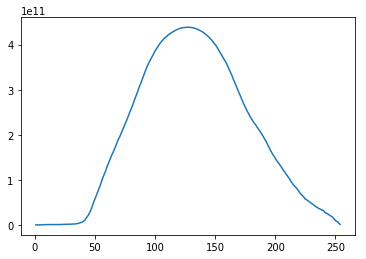

In [9]:
img = readImg("imori.jpg")
s = img2Grey(img)
x = []
ss = []
for i in range(1,255):
    s_0 = s[s<i]
    s_1 = s[s>=i]
    S_b = (np.mean(s_0)-np.mean(s_1))**2*len(s_0)*len(s_1)
    if np.isnan(S_b): S_b = 0
    x.append(i); ss.append(S_b)
plt.plot(x, ss)
plt.show()

127


/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


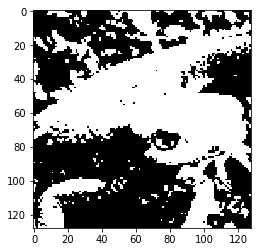

In [10]:
img = readImg("imori.jpg")
s = img2Grey(img)
maxtr = -1
tmpval = 0
for i in range(1,255):
    s_0 = s[s<i]
    s_1 = s[s>=i]
    S_b = (np.mean(s_0)-np.mean(s_1))**2*len(s_0)*len(s_1)
    if np.isnan(S_b): S_b = 0
    if tmpval<S_b: maxtr=i; tmpval=S_b
print(maxtr)
p = np.where(s<maxtr,0,255)
img = RGB2img(p,p,p)
plt.imshow(img)

## Q.5. HSV変換

In [11]:
def RGB2HSV(R,G,B):
    if(R.shape!=G.shape or G.shape!=B.shape or B.shape!=R.shape):
        raise "not match shape R,G,B"
    if(R.dtype!=np.uint8 or G.dtype!=np.uint8 or B.dtype!=np.uint8):
        raise "please set dtype np.uint8"
    Max, Min = np.array([R,G,B]).max(axis=0),np.array([R,G,B]).min(axis=0)
    V = Max/255
    S = (Max-Min)/255
    H = np.zeros_like(R,dtype=np.int32)
    H = np.where(Min==Max, 0, H)
    H = np.where((Min!=Max)&(Min==B),(60*((G-R)/(Max-Min))+60 )%360,H)
    H = np.where((Min!=Max)&(Min==R),(60*((B-G)/(Max-Min))+180)%360,H)
    H = np.where((Min!=Max)&(Min==G),(60*((R-B)/(Max-Min))+300)%360,H)
    return H.astype(np.int32),S,V
def HSV2RGB(H,S,V):
    if(H.shape!=S.shape or S.shape!=V.shape or V.shape!=H.shape):
        raise "not match shape R,G,B"
    if(H.dtype!=np.int32 or S.dtype!=np.float64 or V.dtype!=np.float64):
        raise "please set dtype np.int32(H) and np.float64(S,V)"
    X = S*(1-np.abs(((H%120)/60.)-1))
    R,G,B = V-S,V-S,V-S
    R,G,B = np.where(H//60==0,(V,    V-S+X,V-S  ),(R,G,B))
    R,G,B = np.where(H//60==1,(V-S+X,V,    V-S  ),(R,G,B))
    R,G,B = np.where(H//60==2,(V-S,  V,    V-S+X),(R,G,B))
    R,G,B = np.where(H//60==3,(V-S,  V-S+X,V    ),(R,G,B))
    R,G,B = np.where(H//60==4,(V-S+X,V-S,  V    ),(R,G,B))
    R,G,B = np.where(H//60==5,(V,    V-S,  V-S+X),(R,G,B))
    R,G,B = np.where(H//60==6,(V,    V-S,  V-S+X),(R,G,B))
    return (R*255).astype(np.uint8),(G*255).astype(np.uint8),(B*255).astype(np.uint8)

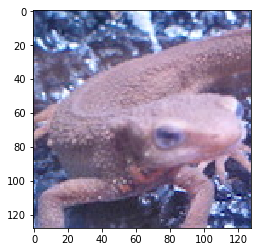

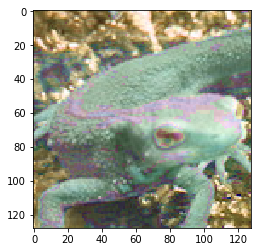

In [12]:
img = readImg("imori.jpg")
plt.imshow(img)
plt.show()
R,G,B = img2RGB(img)
H,S,V = RGB2HSV(R,G,B)
H = (H+180)%360
R,G,B = HSV2RGB(H,S,V)
img = RGB2img(R,G,B)
plt.imshow(img)

## Q.6. 減色処理

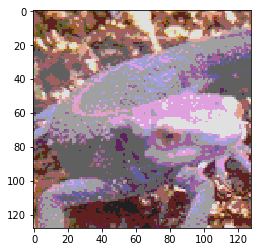

In [13]:
img = cv2.imread(assetsDir+"imori.jpg")
res = img//64*64+32
plt.imshow(res)

## Q.7. 平均プーリング

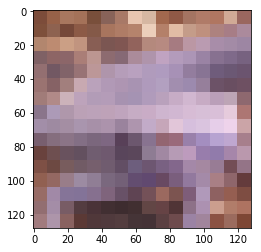

In [14]:
img = cv2.imread(assetsDir+"imori.jpg")
res = np.zeros_like(img)
for i,j,k in itertools.product(range(16),range(16),range(3)):
    res[i*8:i*8+8,j*8:j*8+8,k] = np.mean(img[i*8:i*8+8,j*8:j*8+8,k])
plt.imshow(res)    

## Q.8. Maxプーリング

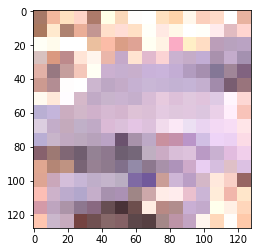

In [15]:
img = cv2.imread(assetsDir+"imori.jpg")
res = np.zeros_like(img)
for i,j,k in itertools.product(range(16),range(16),range(3)):
    res[i*8:i*8+8,j*8:j*8+8,k] = np.max(img[i*8:i*8+8,j*8:j*8+8,k])
plt.imshow(res)

## Q.9. ガウシアンフィルタ

#### for文オジサンは遅い

In [16]:
def bound(img,x,y,c):
    if(x<0 or x>127 or y<0 or y>127): return 0
    return img[x,y,c]
def gaussian(img,x,y,c):
    li = [1,2,1,2,4,2,1,2,1]
    return sum([li[i*3+j]*bound(img,x+i-1,y+j-1,c) for i,j in itertools.product(range(3),range(3))])/16

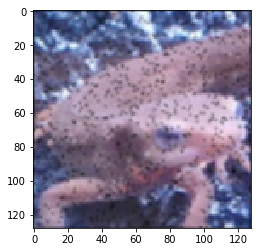

In [17]:
img = readImg("imori_noise.jpg")
res = np.zeros_like(img)
fil = [1/16, 2/16, 1/16, 2/16, 4/16, 2/16, 1/16, 2/16, 1/16]
for i,j,k in itertools.product(range(128),range(128),range(3)):
    res[i,j,k] = gaussian(img,i,j,k)
plt.imshow(res)

#### numpyの演算を用いる

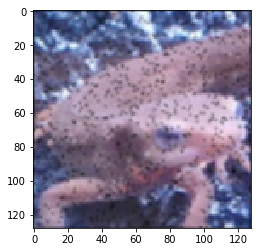

In [31]:
img = readImg("imori_noise.jpg")
res = np.zeros_like(img,dtype=np.float64)
fil = [[1,2,1],[2,4,2],[1,2,1]]
for i,j in itertools.product(range(3),range(3)):
    layer = img.copy()
    if i==0: layer = np.insert(np.delete(layer,127,axis=0),  0,0,axis=0)
    if i==2: layer = np.insert(np.delete(layer,  0,axis=0),127,0,axis=0)
    if j==0: layer = np.insert(np.delete(layer,127,axis=1),  0,0,axis=1)
    if j==2: layer = np.insert(np.delete(layer,  0,axis=1),127,0,axis=1)
    res += fil[i][j]/16*layer
res = res.astype(np.uint8)
plt.imshow(res)

## Q.10. メディアンフィルタ

### for文オジサンは遅い

In [18]:
def median(img,x,y,c):
    return np.median([bound(img,x+i-1,y+j-1,c) for i,j in itertools.product(range(3),range(3))])

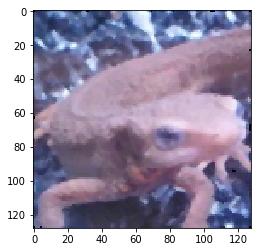

In [19]:
img = readImg("imori_noise.jpg")
res = np.zeros_like(img)
for i,j,k in itertools.product(range(128),range(128),range(3)):
    res[i,j,k] = median(img,i,j,k)
plt.imshow(res)

### numpy演算を使う

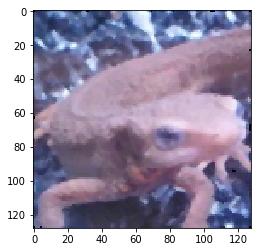

In [45]:
img = readImg("imori_noise.jpg")
restmp = []
for i,j in itertools.product(range(3),range(3)):
    layer = img.copy()
    if i==0: layer = np.insert(np.delete(layer,127,axis=0),  0,0,axis=0)
    if i==2: layer = np.insert(np.delete(layer,  0,axis=0),127,0,axis=0)
    if j==0: layer = np.insert(np.delete(layer,127,axis=1),  0,0,axis=1)
    if j==2: layer = np.insert(np.delete(layer,  0,axis=1),127,0,axis=1)
    restmp.append(layer)
res = np.median(np.array(restmp),axis=0)
res = res.astype(np.uint8)
plt.imshow(res)